In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/cleaned_student_depression_dataset.csv')

In [106]:
# print(df['Degree'].unique())
print(df['City'].unique())

degree_category_map = {
    "Class 12": "School",
    "BA": "Arts_Commerce_Management",
    "MA": "Arts_Commerce_Management",
    "B.Com": "Arts_Commerce_Management",
    "M.Com": "Arts_Commerce_Management",
    "BBA": "Arts_Commerce_Management",
    "MBA": "Arts_Commerce_Management",
    "BSc": "Science_IT",
    "MSc": "Science_IT",
    "BCA": "Science_IT",
    "MCA": "Science_IT",
    "BE": "Engineering_Architecture",
    "B.Tech": "Engineering_Architecture",
    "ME": "Engineering_Architecture",
    "M.Tech": "Engineering_Architecture",
    "B.Arch": "Engineering_Architecture",
    "MBBS": "Medical_Pharma",
    "MD": "Medical_Pharma",
    "B.Pharm": "Medical_Pharma",
    "M.Pharm": "Medical_Pharma",
    "LLB": "Law_Education_Hospitality",
    "LLM": "Law_Education_Hospitality",
    "B.Ed": "Law_Education_Hospitality",
    "M.Ed": "Law_Education_Hospitality",
    "BHM": "Law_Education_Hospitality",
    "MHM": "Law_Education_Hospitality",
    "PhD": "Doctorate_Others",
    "Others": "Doctorate_Others"
}

city_to_region = {
    
    'Bangalore': 'South',
    'Chennai': 'South',
    'Hyderabad': 'South',
    'Visakhapatnam': 'South',


    'Srinagar': 'North',
    'Varanasi': 'North',
    'Jaipur': 'North',
    'Lucknow': 'North',
    'Meerut': 'North',
    'Agra': 'North',
    'Ghaziabad': 'North',
    'Faridabad': 'North',
    'Delhi': 'North',
    'Kanpur': 'North',
    'Patna': 'North',
    'Ludhiana': 'North',


    'Mumbai': 'West',
    'Thane': 'West',
    'Pune': 'West',
    'Nashik': 'West',
    'Vadodara': 'West',
    'Kalyan': 'West',
    'Rajkot': 'West',
    'Ahmedabad': 'West',
    'Surat': 'West',
    'Indore': 'West',  

    
    'Kolkata': 'East',
    
    'Bhopal': 'Central',

    'Unknown': 'Unknown'
}

['Visakhapatnam' 'Bangalore' 'Srinagar' 'Varanasi' 'Jaipur' 'Pune' 'Thane'
 'Chennai' 'Nagpur' 'Nashik' 'Vadodara' 'Kalyan' 'Rajkot' 'Ahmedabad'
 'Kolkata' 'Mumbai' 'Lucknow' 'Indore' 'Surat' 'Ludhiana' 'Bhopal'
 'Meerut' 'Agra' 'Ghaziabad' 'Hyderabad' 'Vasai-Virar' 'Kanpur' 'Patna'
 'Faridabad' 'Delhi' 'Unknown']


In [107]:
# Prepare 3 datasets to try logistic regression on to figure out how to deal with City and Degree. Base - drop region, Grouped - group and one hot encode, Freq - use frequency encoding
df_base = df.copy()
df_grouped = df.drop(columns=['Suicidal_Thoughts'])
df_freq = df.drop(columns=['Suicidal_Thoughts'])

df_base = df_base.drop(columns=['City', 'Degree'])
df_base_reduced = df.drop(columns=['City', 'Degree', 'Suicidal_Thoughts'])

In [108]:
#Function to run logistic regression and tune hyperparameters
def tune_logistic_regression(df, random_state=19, scoring='roc_auc'):
    
    test_size = 0.2
    cv_folds = 5
    
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced'],
        'max_iter': [1000]
    }
    
    # Separate features and target
    X = df.drop('Depression', axis=1)
    y = df['Depression']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Standardise features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Cross-validation
    cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    log_reg = LogisticRegression(random_state=random_state)
    
    # Grid search
    grid_search = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=True
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    #Output results
    results = {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'grid_search': grid_search,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'feature_names': X.columns.tolist()
    }
    
    return results

In [109]:
def evaluate_model(results, plot=True):
    
    best_model = results['best_model']
    X_test_scaled = results['X_test_scaled']
    y_test = results['y_test']
    feature_names = results['feature_names']
    
    # Make predictions
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    print("\n" + "="*60)
    print("TEST SET EVALUATION")
    print("="*60)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Depression', 'Depression']))
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    if plot:
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        
        # Confusion matrix heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                    xticklabels=['No Depression', 'Depression'],
                    yticklabels=['No Depression', 'Depression'])
        axes[0, 0].set_title('Confusion Matrix')
        axes[0, 0].set_ylabel('True Label')
        axes[0, 0].set_xlabel('Predicted Label')
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        axes[0, 1].plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.4f})', linewidth=2)
        axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].set_title('ROC Curve')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
        
        # Feature importance
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': best_model.coef_[0]
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        axes[1, 0].barh(coef_df['Feature'], coef_df['Coefficient'])
        axes[1, 0].set_xlabel('Coefficient Value')
        axes[1, 0].set_title('Feature Importance')
        axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
        
        # Cross Validation scores distribution
        cv_results = results['grid_search'].cv_results_
        axes[1, 1].hist(cv_results['mean_test_score'], bins=30, edgecolor='black', alpha=0.7)
        axes[1, 1].axvline(results['best_score'], color='red', linestyle='--', 
                          linewidth=2, label=f'Best: {results["best_score"]:.4f}')
        axes[1, 1].set_xlabel('Mean CV Score')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('CV Scores Distribution')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()
    
    return {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

In [110]:
results = tune_logistic_regression(df_base)

print("Best Hyperparameters:")
print(results['best_params'])
print(f"\nBest CV ROC-AUC Score: {results['best_score']:.4f}")

eval_results = evaluate_model(results, plot=False)

Best Hyperparameters:
{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

Best CV ROC-AUC Score: 0.9213

TEST SET EVALUATION

Classification Report:
               precision    recall  f1-score   support

No Depression       0.80      0.83      0.82      2310
   Depression       0.88      0.86      0.87      3258

     accuracy                           0.84      5568
    macro avg       0.84      0.84      0.84      5568
 weighted avg       0.85      0.84      0.85      5568


ROC-AUC Score: 0.9208

Confusion Matrix:
[[1911  399]
 [ 465 2793]]


Best Hyperparameters:
{'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}

Best CV ROC-AUC Score: 0.8721

TEST SET EVALUATION

Classification Report:
               precision    recall  f1-score   support

No Depression       0.74      0.78      0.76      2310
   Depression       0.84      0.81      0.82      3258

     accuracy                           0.80      5568
    macro avg       0.79      0.79      0.79      5568
 weighted avg       0.80      0.80      0.80      5568


ROC-AUC Score: 0.8713

Confusion Matrix:
[[1801  509]
 [ 632 2626]]


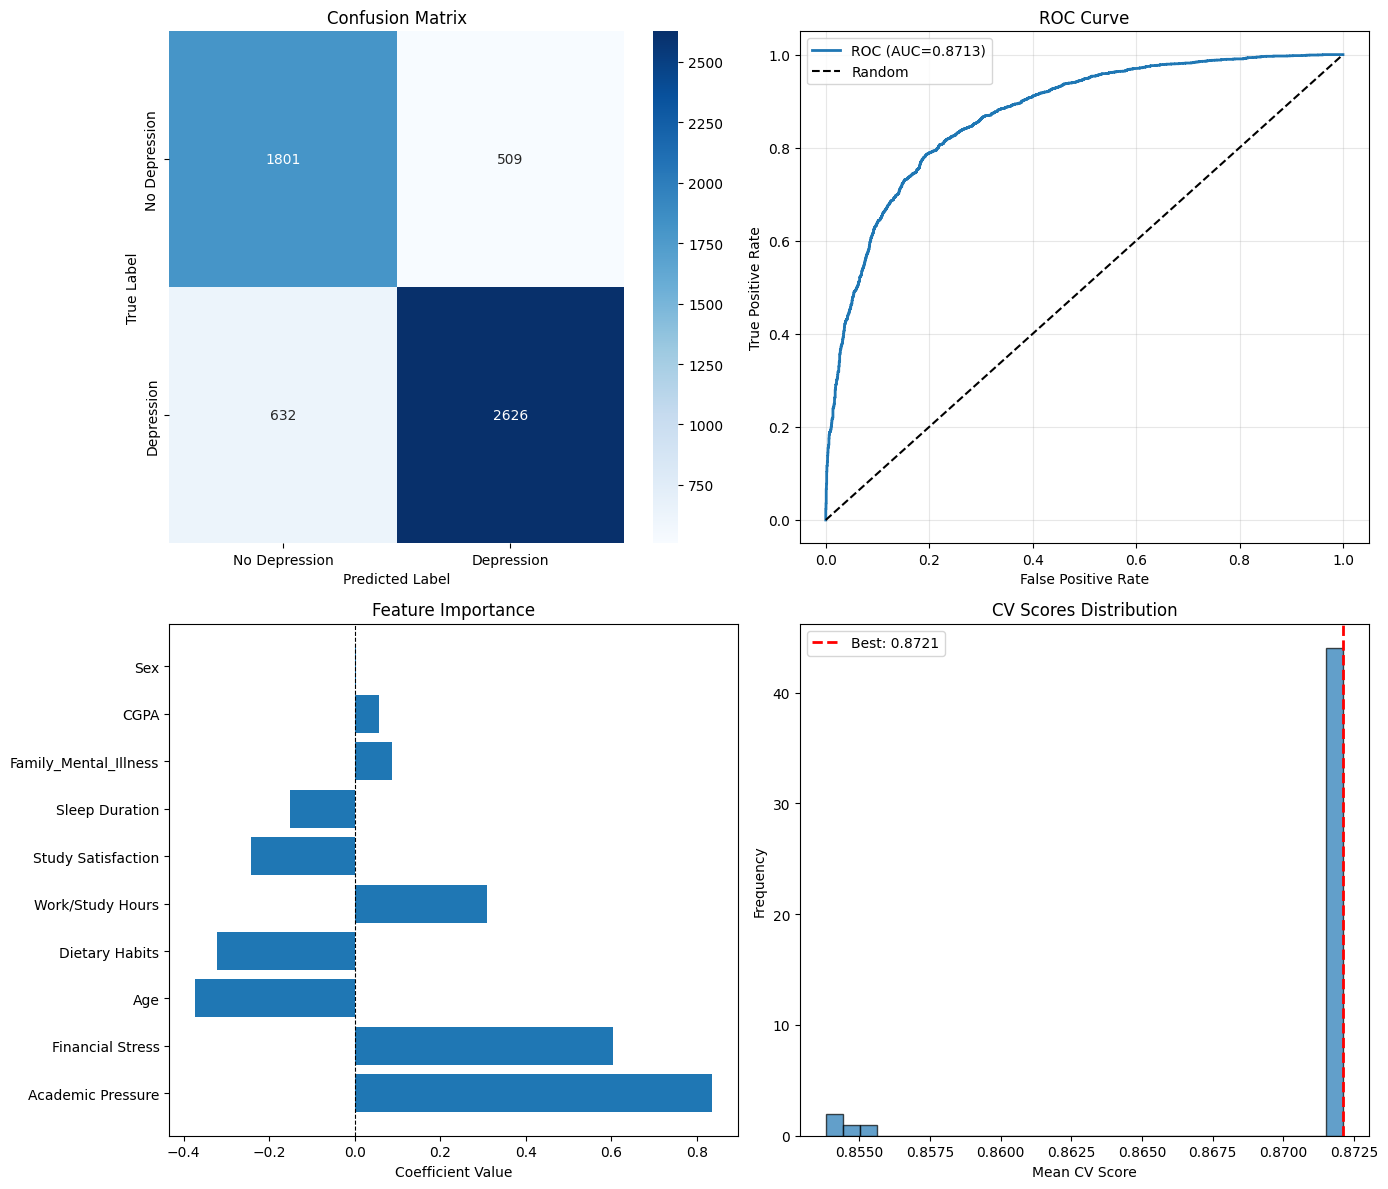

In [111]:
results_reduced = tune_logistic_regression(df_base_reduced)

print("Best Hyperparameters:")
print(results_reduced['best_params'])
print(f"\nBest CV ROC-AUC Score: {results_reduced['best_score']:.4f}")

eval_results_reduced = evaluate_model(results_reduced)

Best Hyperparameters:
{'C': 0.001, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}

Best CV ROC-AUC Score: 0.8666

TEST SET EVALUATION

Classification Report:
               precision    recall  f1-score   support

No Depression       0.79      0.66      0.72      2310
   Depression       0.78      0.87      0.83      3258

     accuracy                           0.78      5568
    macro avg       0.78      0.76      0.77      5568
 weighted avg       0.78      0.78      0.78      5568


ROC-AUC Score: 0.8573

Confusion Matrix:
[[1514  796]
 [ 410 2848]]


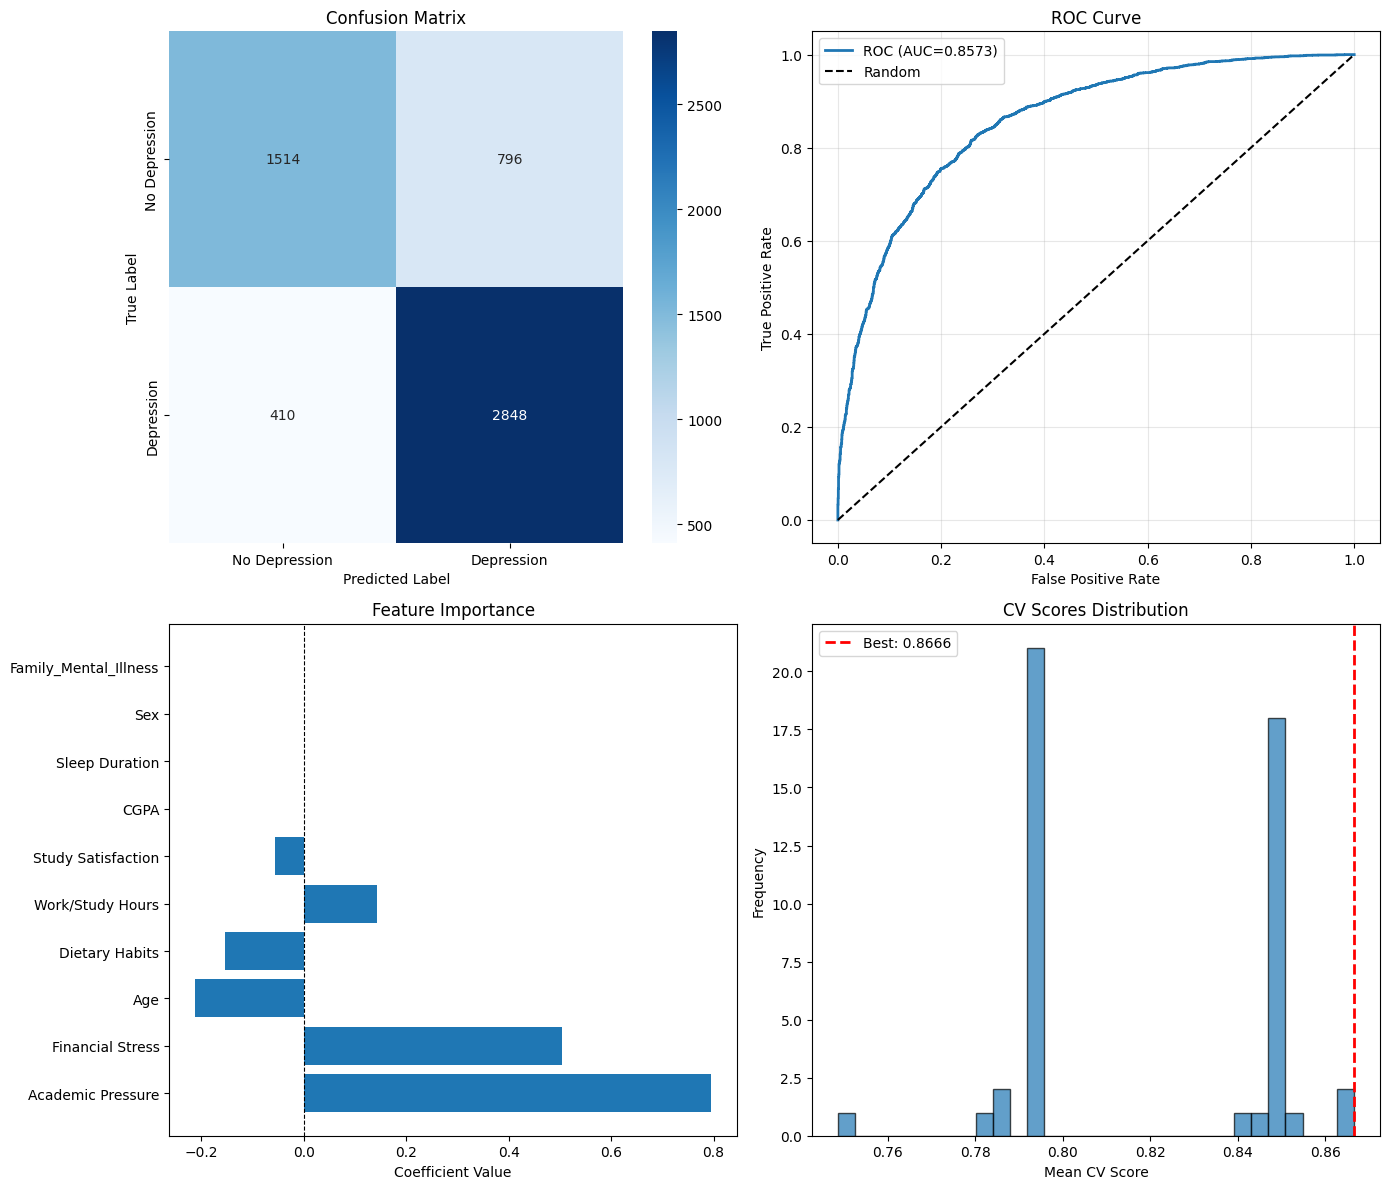

In [112]:
results_reduced_recall = tune_logistic_regression(df_base_reduced, scoring='recall')

print("Best Hyperparameters:")
print(results_reduced_recall['best_params'])
print(f"\nBest CV ROC-AUC Score: {results_reduced_recall['best_score']:.4f}")

eval_results_reduced_recall = evaluate_model(results_reduced_recall)

In [113]:
# Map Degree and Region into broader groups
df_grouped['Grouped_Degree']=df_grouped['Degree'].map(degree_category_map)
#print(df_grouped['Grouped_Degree'].value_counts())
df_grouped = df_grouped.drop(columns=['Degree'])

df_grouped['Region']=df_grouped['City'].map(city_to_region)
#print(df_grouped['Region'].value_counts())
df_grouped = df_grouped.drop(columns=['City'])

# One hot encode for each of the grouped variables
df_grouped = pd.get_dummies(
    df_grouped,
    columns=['Grouped_Degree', 'Region'],
    drop_first=True,
    dtype=int
)
# df_grouped.head()

In [114]:
grouped_results = tune_logistic_regression(df_grouped)

print("Best Hyperparameters:")
print(results['best_params'])
print(f"\nBest CV ROC-AUC Score: {grouped_results['best_score']:.4f}")

eval_results_grouped = evaluate_model(grouped_results, plot=False)

Best Hyperparameters:
{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

Best CV ROC-AUC Score: 0.8722

TEST SET EVALUATION

Classification Report:
               precision    recall  f1-score   support

No Depression       0.74      0.78      0.76      2310
   Depression       0.84      0.81      0.82      3258

     accuracy                           0.79      5568
    macro avg       0.79      0.79      0.79      5568
 weighted avg       0.80      0.79      0.80      5568


ROC-AUC Score: 0.8710

Confusion Matrix:
[[1795  515]
 [ 628 2630]]


In [115]:
#Frequency encode Degree and Region
degree_freq = df_freq['Degree'].value_counts(normalize=True)
df_freq['Degree_freq'] = df_freq['Degree'].map(degree_freq)

city_freq = df_freq['City'].value_counts(normalize=True)
df_freq['City_freq'] = df_freq['City'].map(city_freq)

df_freq = df_freq.drop(columns=['Degree', 'City'])
# df_freq.head()

In [116]:
freq_results = tune_logistic_regression(df_freq)

print("Best Hyperparameters:")
print(results['best_params'])
print(f"\nBest CV ROC-AUC Score: {freq_results['best_score']:.4f}")

eval_results_grouped = evaluate_model(freq_results, plot=False)

Best Hyperparameters:
{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

Best CV ROC-AUC Score: 0.8722

TEST SET EVALUATION

Classification Report:
               precision    recall  f1-score   support

No Depression       0.74      0.78      0.76      2310
   Depression       0.84      0.81      0.82      3258

     accuracy                           0.79      5568
    macro avg       0.79      0.79      0.79      5568
 weighted avg       0.80      0.79      0.80      5568


ROC-AUC Score: 0.8715

Confusion Matrix:
[[1798  512]
 [ 630 2628]]
